# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word Embedding</a></div><div class="lev2 toc-item"><a href="#Read-Pretrained-Model" data-toc-modified-id="Read-Pretrained-Model-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Read Pretrained Model</a></div><div class="lev2 toc-item"><a href="#Use-Word2vec-to-Initialize-Embedding-Matrix" data-toc-modified-id="Use-Word2vec-to-Initialize-Embedding-Matrix-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Use Word2vec to Initialize Embedding Matrix</a></div><div class="lev1 toc-item"><a href="#Build-Dateset" data-toc-modified-id="Build-Dateset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Dateset</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev2 toc-item"><a href="#Train" data-toc-modified-id="Train-63"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Train</a></div><div class="lev2 toc-item"><a href="#Train-(Generator)" data-toc-modified-id="Train-(Generator)-64"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Train (Generator)</a></div><div class="lev2 toc-item"><a href="#plot-results" data-toc-modified-id="plot-results-65"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>plot results</a></div><div class="lev1 toc-item"><a href="#Evaluate" data-toc-modified-id="Evaluate-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluate</a></div>

# Load Data

In [1]:
import json
import os

In [2]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [3]:
sentence = load_data('train_data.json', 'sentence')

# Word Segmentation

In [4]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)')
re_replace = re.compile(u'([^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.])|（(.*?)）|\((.*?)\)')

In [6]:
filename = "stopwords.txt"
stopWords = [w for w in open(filename).read().split()]

In [7]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub('', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in ws if i not in stopWords]

In [8]:
sentWords = [del_stop(newcut(s)) for s in sentence]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/kz/hqjl_dfx3g3_2vxylxlj1s940000gn/T/jieba.cache
Loading model cost 0.989 seconds.
Prefix dict has been built succesfully.


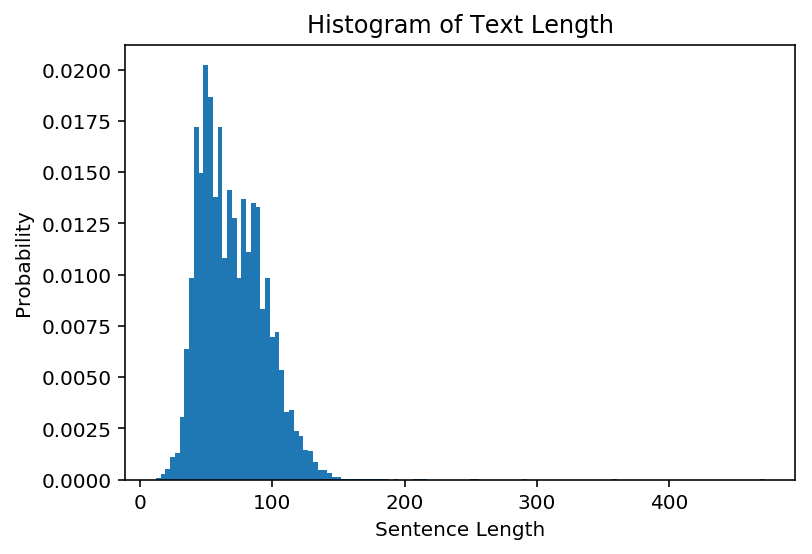

In [9]:
plt.hist([len(i) for i in sentWords], bins=128, normed=True);
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.title('Histogram of Text Length')  

# Tokenize Text

In [10]:
from keras.preprocessing.text import Tokenizer
import numpy as np

Using TensorFlow backend.


In [11]:
tokWords = sentWords.copy()
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
sentLens = np.array([len(i) for i in sentWords])
print('Number of sentences: \t{:d}'.format(len(sentLens)))
print('Distribution of sentence lengths (number of words):')
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))
print('Found %s unique tokens.' % len(word2index))

Number of sentences: 	20332
Distribution of sentence lengths (number of words):
Min: 12   Max: 472   Mean: 69.997   Med: 67.000
Found 55935 unique tokens.


In [12]:
MAX_LEN = 150 # Approximately twice the median length of sentences

# Word Embedding

In [13]:
VOCAB_SIZE = len(index2word)+1
EMBEDDING_SIZE = 256
SEED = 42

## Read Pretrained Model

In [14]:
import gensim

In [15]:
word2vec = gensim.models.Word2Vec.load('/Users/lizhn7/Downloads/DATA/word2vec/word2vec_wx')
word2vec.init_sims(replace=True)
w2v_embedding_weights = word2vec.wv.syn0
w2v_embedding_weights.std()

0.062499415

## Use Word2vec to Initialize Embedding Matrix 

In [16]:
# Generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_SIZE)
scale = w2v_embedding_weights.std() * np.sqrt(12) / 2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [17]:
count = 0
w2v_dict = word2vec.wv.index2word
for i in range(1, VOCAB_SIZE):
    w = index2word[i]
    if w in w2v_dict:
        g = word2vec[w]
        embedding[i, :] = g
        count += 1
print('{num_tokens}-{per:.3f}% tokens in vocab found in word2vec and copied to embedding.'.format(num_tokens=count, per=count/float(VOCAB_SIZE)*100))

37268-66.626% tokens in vocab found in word2vec and copied to embedding.


# Build Dateset

In [70]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [71]:
def convert_seq(ws):
    """
    Pad words sequene to MAX_LEN and encode label to one-hot encoding
    """
    sentText = [' '.join(i) for i in ws]
    sentSeq = tokenizer.texts_to_sequences(sentText)
    sentData = pad_sequences(sentSeq, maxlen=MAX_LEN, padding='post', truncating='post')
    label = embedding[sentData]
    return sentData, label

In [72]:
x, y = convert_seq(sentWords)

In [73]:
xTrain, xVal, yTrain, yVal = train_test_split(x, y, test_size=0.15, random_state=SEED)

# Build Model

In [74]:
MAX_LEN = 150
VOCAB_SIZE = 55936
EMBEDDING_SIZE = 256
LATENT_SIZE = 512
NUM_EPOCHS = 36
BATCH_SIZE = 64
#NUM_TRAIN_STEPS = len(xTrain) // BATCH_SIZE # 222
#NUM_VAL_STEPS = len(xVal) // BATCH_SIZE # 95
NUM_TRAIN_STEPS = 14
NUM_VAL_STEPS = 6

## Import Libraries

In [75]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, RepeatVector
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [76]:
K.clear_session()
inputs = Input(shape=(MAX_LEN,), name='INPUT') 
emb = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, weights=[embedding], mask_zero=True, input_length=MAX_LEN, trainable=False, name='EMBEDDING')(inputs)
encoded = Bidirectional(LSTM(LATENT_SIZE, return_sequences=False, implementation=0), merge_mode='sum', name='ENCODER_BiLSTM')(emb)
decoded = RepeatVector(MAX_LEN, name="REPEATER")(encoded)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, implementation=0), merge_mode='sum', name='DECODER_BiLSTM')(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(loss='mse', optimizer='rmsprop')

## Model Visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 150)               0         
_________________________________________________________________
EMBEDDING (Embedding)        (None, 150, 256)          14319616  
_________________________________________________________________
ENCODER_BiLSTM (Bidirectiona (None, 512)               3149824   
_________________________________________________________________
REPEATER (RepeatVector)      (None, 150, 512)          0         
_________________________________________________________________
DECODER_BiLSTM (Bidirectiona (None, 150, 256)          1574912   
Total params: 19,044,352
Trainable params: 4,724,736
Non-trainable params: 14,319,616
_________________________________________________________________


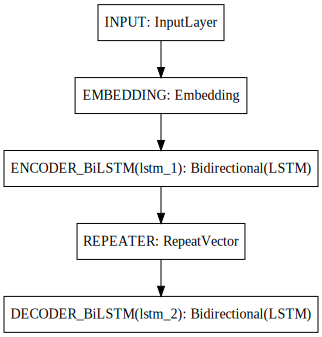

In [77]:
autoencoder.summary()
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

## Train

In [78]:
filepath = '/Users/lizhn7/Downloads/DATA/chinese_news/sent2vec/cp_logs/weights.{epoch:03d}-{val_loss:.6f}.hdf5'
log_string = '/Users/lizhn7/Downloads/DATA/chinese_news/sent2vec/tb_logs/s2v'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir=log_string) 

In [ ]:
history = autoencoder.fit(xTrain,
                    yTrain,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, 
                    verbose=1,
                    callbacks=[checkpoint, tensorboard],
                    validation_data=(xVal, yVal), 
                    shuffle=True)

Train on 17282 samples, validate on 3050 samples
Epoch 1/36
12928/17282 [=====================>........] - ETA: 659s - loss: 0.0070

## Train (Generator)

In [34]:
def sentence_generator(X, embeddings, batch_size):
    """
    Generate batches
    """
    while True:
        # loop once per epoch
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            sids = indices[bid * batch_size : (bid + 1) * batch_size]
            Xbatch = embeddings[X[sids, :]]
            yield Xbatch, Xbatch

In [35]:
# define training and test generators
train_gen = sentence_generator(xTrain, embedding, BATCH_SIZE)
val_gen = sentence_generator(xVal, embedding, BATCH_SIZE)

In [36]:
filepath = '/Users/lizhn7/Downloads/DATA/chinese_news/sent2vec/cp_logs/weights.{epoch:03d}-{val_loss:.6f}.hdf5'
log_string = '/Users/lizhn7/Downloads/DATA/chinese_news/sent2vec/tb_logs/s2v'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir=log_string) 

In [37]:
history = autoencoder.fit_generator(train_gen, 
                                    steps_per_epoch=NUM_TRAIN_STEPS,
                                    epochs=NUM_EPOCHS,
                                    callbacks=[checkpoint, tensorboard],
                                    validation_data=val_gen,
                                    validation_steps=NUM_VAL_STEPS)

Epoch 1/36
14/14 [==============================] - 146s - loss: 0.0052 - val_loss: 0.0030
Epoch 2/36
14/14 [==============================] - 146s - loss: 0.0030 - val_loss: 0.0030
Epoch 3/36
14/14 [==============================] - 146s - loss: 0.0030 - val_loss: 0.0028
Epoch 4/36
14/14 [==============================] - 146s - loss: 0.0029 - val_loss: 0.0029
Epoch 5/36
14/14 [==============================] - 145s - loss: 0.0028 - val_loss: 0.0029
Epoch 6/36
14/14 [==============================] - 147s - loss: 0.0029 - val_loss: 0.0027
Epoch 7/36
14/14 [==============================] - 145s - loss: 0.0028 - val_loss: 0.0028
Epoch 8/36
14/14 [==============================] - 146s - loss: 0.0026 - val_loss: 0.0026
Epoch 9/36
14/14 [==============================] - 145s - loss: 0.0028 - val_loss: 0.0025
Epoch 10/36
14/14 [==============================] - 147s - loss: 0.0026 - val_loss: 0.0026
Epoch 11/36
14/14 [==============================] - 146s - loss: 0.0027 - val_loss: 0.00

## plot results

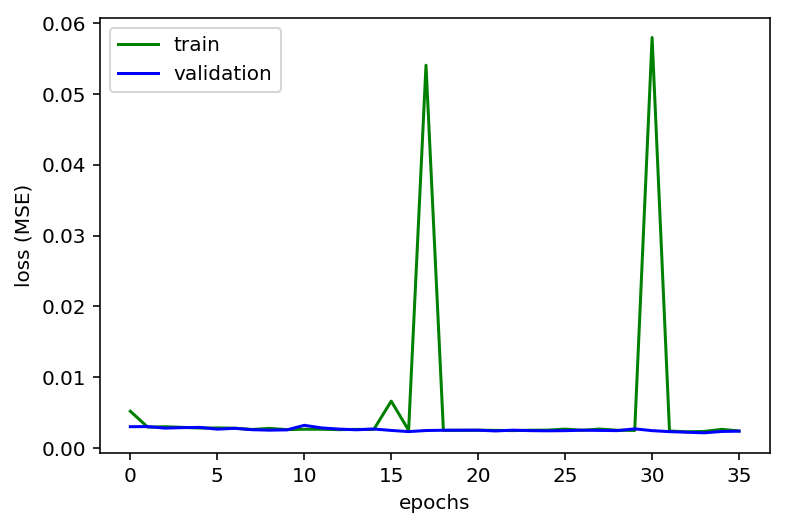

In [39]:
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.ylabel("loss (MSE)")
plt.xlabel("epochs")
plt.legend(loc="best")
plt.show()

# Evaluate

In [38]:
def cosine_similarity(x, y):
    """
    Compute_cosine_similarity
    """
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))

In [43]:
# collect autoencoder predictions for test set
test_inputs, test_labels = next(val_gen)
preds = autoencoder.predict(test_inputs)

In [45]:
# extract encoder part from autoencoder
encoder = Model(autoencoder.input, autoencoder.get_layer("ENCODER_BiLSTM").output)
encoder.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 150, 256)          0         
_________________________________________________________________
ENCODER_BiLSTM (Bidirectiona (None, 512)               3149824   
Total params: 3,149,824
Trainable params: 3,149,824
Non-trainable params: 0
_________________________________________________________________


In [51]:
len(xVal)

6100

0.783562123775
0.79949849844
0.813230037689
0.709799826145
0.788262784481
0.790473043919
0.783529341221
0.761404395103
0.770313739777
0.558278143406
0.780382335186


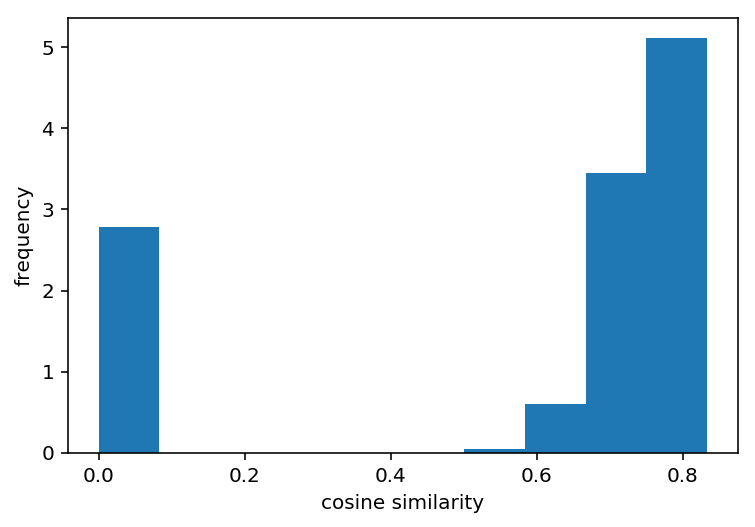

In [50]:
# compute difference between vector produced by original and autoencoded
k = 500
cosims = np.zeros((k))
i = 0
for bid in range(NUM_VAL_STEPS):
    xtest, ytest = next(val_gen)
    ytest_ = autoencoder.predict(xtest)
    Xvec = encoder.predict(xtest)
    Yvec = encoder.predict(ytest_)
    for rid in range(Xvec.shape[0]):
        if i >= k:
            break
        cosims[i] = cosine_similarity(Xvec[rid], Yvec[rid])
        if i <= 10:
            print(cosims[i])
        i += 1
    if i >= k:
        break

plt.hist(cosims, bins=10, normed=True)
plt.xlabel("cosine similarity")
plt.ylabel("frequency")